## MobileNetv2 Model for binary classification between Glaucoma (G) and Normal (N) classes


### 00. Load libraries

In [29]:
!pip install tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Rescaling, Activation, Dropout, Flatten, Dense, GlobalMaxPooling2D, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import VGG16,MobileNetV2,InceptionV3

import os
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

### 01. Load images
The images are separated into train, test and validation using the function of keras call image_dataset_from_directory

In [30]:
train_dir = 'Glaucomadata/train'
test_dir = 'Glaucomadata/test'

BATCH_SIZE = 32
IMG_HEIGHT = 264
IMG_WIDTH = 264
EPOCHS = 100

input_shape = (IMG_WIDTH, IMG_HEIGHT, 3)

In [31]:
# Creating generators (prepare data to feed the model)
training_generator = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='binary',
    batch_size=BATCH_SIZE,
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    shuffle=True,
    seed=432,
    validation_split=0.2,
    subset='training',
).repeat(20)

validation_generator = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='binary',
    batch_size=BATCH_SIZE,
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    shuffle=True,
    seed=432,
    validation_split=0.2,
    subset='validation',
).repeat(20)

test_generator = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='binary',
    shuffle=False,
    batch_size=BATCH_SIZE,
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    seed=432,
)

Found 545 files belonging to 2 classes.
Using 436 files for training.
Found 545 files belonging to 2 classes.
Using 109 files for validation.
Found 89 files belonging to 2 classes.


### 02. Model architecture


In [32]:
pretrained = MobileNetV2(weights='imagenet', include_top=False)

In [33]:
model = Sequential()

model.add(Rescaling(1./255, input_shape=input_shape))

model.add(pretrained)

model.add(Flatten())
model.add(Dense(256, activation='relu'))
#model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
#model.add(Dropout(0.2))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 264, 264, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, None, None, 1280)  2257984  
 ional)                                                          
                                                                 
 flatten_1 (Flatten)         (None, 81920)             0         
                                                                 
 dense_4 (Dense)             (None, 256)               20971776  
                                                                 
 dense_5 (Dense)             (None, 256)               65792     
                                                                 
 dense_6 (Dense)             (None, 256)               65792     
                                                      

### 03. Weight adjustment
As observed in the EDA, the classes were not balanced. In order for the model not to over-train, higher weights are given to those classes with fewer samples.

In [34]:
cat_list = os.listdir('Glaucomadata/train/')
cat_list.sort()

lenghts = [len(os.listdir('Glaucomadata/train/'+cat)) for cat in cat_list]
total_train_images = np.sum(lenghts)

weights = list(np.sqrt(np.round(1/(np.array(lenghts) / total_train_images),2)))

print(cat_list)
print(lenghts)
print(weights)

['advanced', 'normal']
[268, 277]
[1.4247806848775006, 1.40356688476182]


### 04. Model train
We add earlystopping in order to keep the best model. If the model gets worse with increasing iterations, we will keep the best one.

For the learning_rate, a small value (0.001) is set so that the different combinations of parameters can be correctly explored until the optimum is reached.

Weights from the VGG16 model are freezed so they will not update over the training and binary crossentropy loss with Adam optimizer is used for the loss function.

The number of epochs was set at 100 in order to appreciate the evolution of the model during training.

In [35]:
patience = 10

early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

In [36]:

pretrained.trainable = False

model.compile(loss='binary_crossentropy', loss_weights=weights,
            optimizer=Adam(learning_rate=0.001),
            metrics=['accuracy'])

In [37]:
# Training
history = model.fit(
    training_generator,
    steps_per_epoch=10,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=10,
    verbose=1,
    callbacks = [early_stopping])

Epoch 1/100
10/10 [==============================] - 9s 489ms/step - loss: 11.5855 - accuracy: 0.6094 - val_loss: 3.6560 - val_accuracy: 0.6560
Epoch 2/100
10/10 [==============================] - 3s 368ms/step - loss: 1.9732 - accuracy: 0.7565 - val_loss: 0.5270 - val_accuracy: 0.8404
Epoch 3/100
10/10 [==============================] - 3s 286ms/step - loss: 0.8498 - accuracy: 0.8214 - val_loss: 1.6242 - val_accuracy: 0.6383
Epoch 4/100
10/10 [==============================] - 2s 242ms/step - loss: 0.5767 - accuracy: 0.8906 - val_loss: 0.6608 - val_accuracy: 0.8582
Epoch 5/100
10/10 [==============================] - 3s 274ms/step - loss: 0.1668 - accuracy: 0.9675 - val_loss: 0.4763 - val_accuracy: 0.8617
Epoch 6/100
10/10 [==============================] - 3s 271ms/step - loss: 0.1102 - accuracy: 0.9708 - val_loss: 0.5778 - val_accuracy: 0.8475
Epoch 7/100
10/10 [==============================] - 2s 232ms/step - loss: 0.0671 - accuracy: 0.9838 - val_loss: 0.5928 - val_accuracy: 0.872

In [38]:
model.save('mobilenet_binary_glaucoma_normal.h5')

### 05. Analysis of results

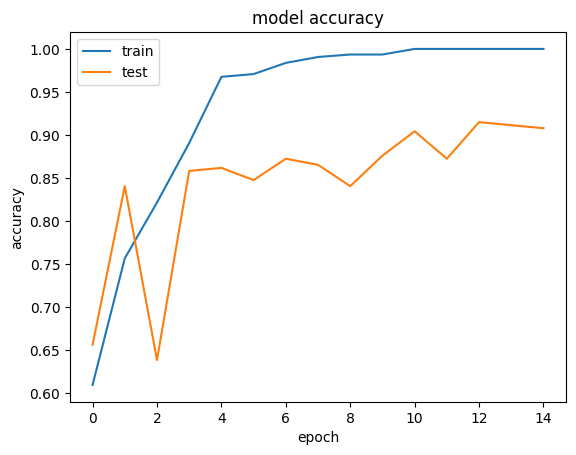

In [39]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

The accuracy evolves positively throughout the training period resulting in values close to 1 providing a model with very good results.

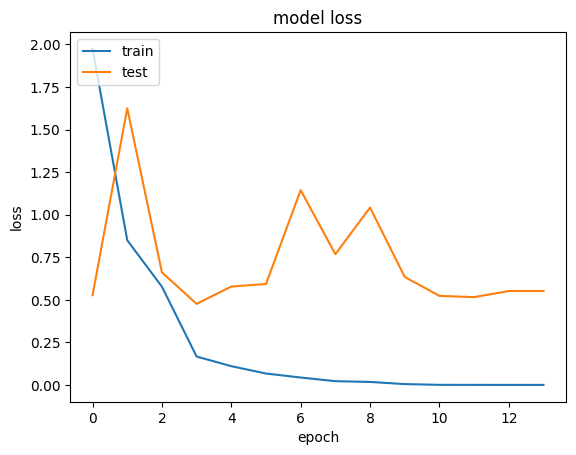

In [40]:
# summarize history for loss
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'][1:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In the case of loss, it is observed that as the epochs increase, their value decreases gradually until it flats, which is good for the model precision.

In [41]:
model = load_model('mobilenet_binary_glaucoma_normal.h5')

In [42]:
## Predict on test data
y_pred = model.predict(test_generator)

3/3 [==============================] - 2s 591ms/step


In [43]:
test_labels = []
for image_batch, labels_batch in test_generator:
  for vector in labels_batch:
    test_labels.append(vector.numpy().astype(int))

y_real = np.array(test_labels)

In [44]:
y_pred[y_pred >= 0.5] = 1
y_pred[y_pred < 0.5] = 0

Text(50.722222222222214, 0.5, 'Truth')

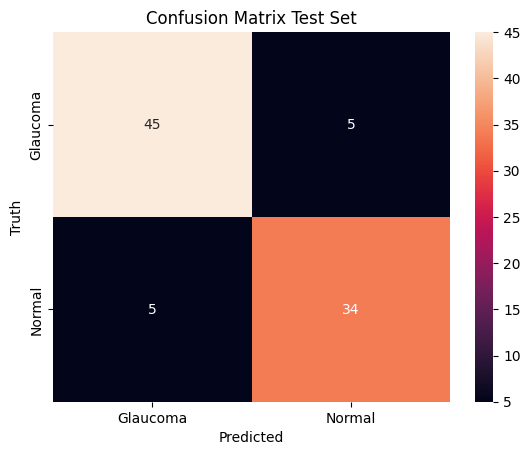

In [46]:
cf_matrix = confusion_matrix(y_real, y_pred)
ax = sns.heatmap(cf_matrix, annot=True, fmt='d')
plt.title('Confusion Matrix Test Set')
ax.xaxis.set_ticklabels(['Glaucoma','Normal'])
ax.yaxis.set_ticklabels(['Glaucoma','Normal'])
plt.xlabel('Predicted')
plt.ylabel('Truth')

The confusion matrix for the test set is almost perfect, only missclassifies one Cataract sample, resulting in almost 100% accuracy for both classes. This model passes the test filter and could be considered for production.

In [47]:
print(classification_report(y_real, y_pred, target_names=['Glaucoma','Normal']))

              precision    recall  f1-score   support

    Glaucoma       0.90      0.90      0.90        50
      Normal       0.87      0.87      0.87        39

    accuracy                           0.89        89
   macro avg       0.89      0.89      0.89        89
weighted avg       0.89      0.89      0.89        89



In [28]:
img=Image.open("TEST1.jpg")
img=img.resize((264,264))
print(img.size)


FileNotFoundError: [Errno 2] No such file or directory: 'TEST1.jpg'

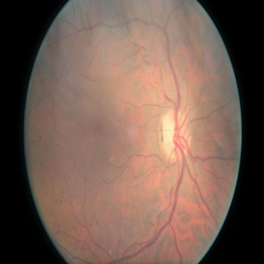

In [19]:
img

In [20]:
x=np.array(img)
prediction=model.predict(x)
print(prediction)

ValueError: in user code:

    File "C:\Users\suraj\anaconda3\lib\site-packages\keras\engine\training.py", line 2169, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\suraj\anaconda3\lib\site-packages\keras\engine\training.py", line 2155, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\suraj\anaconda3\lib\site-packages\keras\engine\training.py", line 2143, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\suraj\anaconda3\lib\site-packages\keras\engine\training.py", line 2111, in predict_step
        return self(x, training=False)
    File "C:\Users\suraj\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\suraj\anaconda3\lib\site-packages\keras\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1" is incompatible with the layer: expected shape=(None, 264, 264, 3), found shape=(None, 264, 3)
